Project Scope:
- Energy Consumption: Power readings in Watts (W) for House devices.
- Device-Level: REFIT House 2 has Aggregate + 9 appliances (Fridge, Microwave, etc.).
- Prediction Target: Hourly total energy consumption (Wh) for next 24 hours.
- Insights: Hourly/Daily/Weekly trends per device.


Install Dependencies

In [ ]:
!pip install -q pandas>=2.1 numpy>=1.26 matplotlib>=3.8 seaborn>=0.13 \
  scikit-learn>=1.3 pyyaml>=6.0 pyarrow>=14.0 joblib>=1.3

print("✅ Dependencies installed!")

✅ Dependencies installed!


 Mount Drive & Setup Directory Structure

In [ ]:
import os

USE_DRIVE = True  # Keep True to save in your Drive

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE = '/content/drive/MyDrive/smart-energy'
else:
    BASE = '/content/smart-energy'

# Create all required directories
directories = [
    f'{BASE}/configs',
    f'{BASE}/data/raw',
    f'{BASE}/data/processed',
    f'{BASE}/data/processed/splits',
    f'{BASE}/models',
    f'{BASE}/notebooks',
    f'{BASE}/reports/figures',
    f'{BASE}/scripts',
]

for p in directories:
    os.makedirs(p, exist_ok=True)

os.chdir(BASE)
print("✅ Working directory:", os.getcwd())
print("✅ Directory structure created!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Working directory: /content/drive/MyDrive/smart-energy
✅ Directory structure created!


 Download Dataset from Zenodo

In [ ]:
import os
import requests
import shutil

os.makedirs("data/raw", exist_ok=True)

rec_id = 5063428
rec = requests.get(f"https://zenodo.org/api/records/{rec_id}").json()

# Find the House 2 file in the record
target_key = "CLEAN_House2.csv"
file_obj = None
for f in rec.get("files", []):
    if f["key"].lower() == target_key.lower():
        file_obj = f
        break

if not file_obj:
    available = [f['key'] for f in rec.get('files', [])]
    raise SystemExit(f"{target_key} not found. Available: {available}")

# Get download URL
links = file_obj.get("links", {})
url = links.get("content") or links.get("self") or f"https://zenodo.org/records/{rec_id}/files/{target_key}?download=1"
print("Downloading from:", url)

# Download file
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open("data/raw/CLEAN_House2.csv", "wb") as out:
        shutil.copyfileobj(r.raw, out)

print("✅ Saved to data/raw/CLEAN_House2.csv")

✅ Saved to data/raw/CLEAN_House2.csv


 Handle Compression (if file is gzip/zip)

In [ ]:
import os
import gzip
import shutil
import zipfile

path = "data/raw/CLEAN_House2.csv"
assert os.path.exists(path), "CLEAN_House2.csv not found in data/raw!"

# Detect type by magic bytes
with open(path, "rb") as f:
    sig = f.read(4)

if sig[:2] == b"\x1f\x8b":  # gzip
    os.rename(path, path + ".gz")
    with gzip.open(path + ".gz", "rb") as fin, open(path, "wb") as fout:
        shutil.copyfileobj(fin, fout)
    os.remove(path + ".gz")
    print("✅ Decompressed gzip ->", path)

elif sig[:2] == b"PK":  # zip
    os.rename(path, path + ".zip")
    with zipfile.ZipFile(path + ".zip") as z:
        members = [n for n in z.namelist() if n.lower().endswith(".csv") and "house2" in n.lower()]
        if not members:
            members = [n for n in z.namelist() if n.lower().endswith(".csv")]
        assert members, "No CSV found inside the zip."
        target = members[0]
        z.extract(target, "data/raw_extracted")
        src = os.path.join("data/raw_extracted", target)
        shutil.move(src, "data/raw/CLEAN_House2.csv")
    os.remove(path + ".zip")
    print("✅ Unzipped -> data/raw/CLEAN_House2.csv")
else:
    print("✅ File is already a plain CSV.")

✅ Decompressed gzip -> data/raw/CLEAN_House2.csv


Create Config File

In [ ]:
%%writefile configs/config.yml
data:
  raw_path: "data/raw/CLEAN_House2.csv"
  columns:
    timestamp: "Time"
    unix: "Unix"
  target_type: "power"  # REFIT values are Watts
  input_tz: "Europe/London"
  output_tz: "UTC"
  resample:
    hourly_freq: "h"
    daily_freq: "D"
  imputation:
    method: "ffill_bfill"
    max_gap_hours: 24

outliers:
  clip_lower: 0
  clip_upper: 5000  # Watts

split:
  train_ratio: 0.70
  val_ratio: 0.15
  test_ratio: 0.15

outputs:
  processed_dir: "data/processed"
  hourly_path: "data/processed/hourly_energy.csv"
  daily_path: "data/processed/daily_energy.csv"
  splits_dir: "data/processed/splits"
  figures_dir: "reports/figures"

Overwriting configs/config.yml


 Load and Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print(" DATA COLLECTION AND UNDERSTANDING OF DATA")
print("=" * 60)

# Load raw data
raw_path = "data/raw/CLEAN_House2.csv"
df = pd.read_csv(raw_path, low_memory=False)

# Clean column names (strip whitespace)
df.columns = df.columns.str.strip()

print("\n📊 INITIAL DATA OVERVIEW:")
print("-" * 40)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

 DATA COLLECTION AND UNDERSTANDING OF DATA

📊 INITIAL DATA OVERVIEW:
----------------------------------------
Shape: 5,733,526 rows × 13 columns

Columns: ['Time', 'Unix', 'Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9', 'Issues']

Data Types:
Time          object
Unix           int64
Aggregate      int64
Appliance1     int64
Appliance2     int64
Appliance3     int64
Appliance4     int64
Appliance5     int64
Appliance6     int64
Appliance7     int64
Appliance8     int64
Appliance9     int64
Issues         int64
dtype: object

First 5 rows:


,Time,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
0,2013-09-17 22:08:11,1379455691,695,88,0,0,0,0,0,0,0,0,0
1,2013-09-17 22:08:18,1379455698,694,88,0,0,0,0,0,0,0,0,0
2,2013-09-17 22:08:26,1379455706,694,88,0,0,0,0,0,0,0,0,0
3,2013-09-17 22:08:34,1379455714,702,88,0,0,0,0,0,0,0,0,0
4,2013-09-17 22:08:42,1379455722,700,88,0,0,0,0,0,0,0,0,0


 Data Integrity Check

In [ ]:
print("\n📋 DATA INTEGRITY CHECK:")
print("-" * 40)

# Check for required columns
required_cols = ['Time', 'Unix']
for col in required_cols:
    assert col in df.columns, f"Missing required column: {col}"
print("✅ Required columns present (Time, Unix)")

# Identify device/appliance columns
device_cols = [c for c in df.columns if c not in ['Time', 'Unix', 'Issues']]
print(f"✅ Found {len(device_cols)} device columns: {device_cols}")

# Check for Issues column and drop if exists
if 'Issues' in df.columns:
    print(f"⚠️ Dropping 'Issues' column (not needed for analysis)")
    df = df.drop(columns=['Issues'])

# Missing values check
print(f"\n📉 MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
print(missing_df[missing_df['Missing'] > 0])
if missing.sum() == 0:
    print("✅ No missing values found!")

# Duplicates check
print(f"\n🔄 DUPLICATES:")
duplicates = df.duplicated().sum()
print(f"Full row duplicates: {duplicates:,}")

# Check timestamp duplicates specifically
time_duplicates = df.duplicated(subset=['Time']).sum()
print(f"Timestamp duplicates: {time_duplicates:,}")


📋 DATA INTEGRITY CHECK:
----------------------------------------
✅ Required columns present (Time, Unix)
✅ Found 10 device columns: ['Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9']
⚠️ Dropping 'Issues' column (not needed for analysis)

📉 MISSING VALUES:
Empty DataFrame
Columns: [Missing, Percent]
Index: []
✅ No missing values found!

🔄 DUPLICATES:
Full row duplicates: 0
Timestamp duplicates: 0


 Data Cleaning and Preprocessing

In [ ]:
print("\n" + "=" * 60)
print(" DATA CLEANING AND PREPROCESSING")
print("=" * 60)

# Define power columns (Aggregate + all Appliances)
power_cols = ['Aggregate'] + [col for col in df.columns if 'Appliance' in col]
power_cols = [c for c in power_cols if c in df.columns]
print(f"\n⚡ Power columns to process: {power_cols}")

# 1. Remove duplicates (based on timestamp + power readings)
print("\n🧹 STEP 1: Removing duplicates...")
initial_rows = len(df)
df = df.drop_duplicates(subset=['Time'] + power_cols, keep='first')
removed = initial_rows - len(df)
print(f"   Removed {removed:,} duplicate rows")
print(f"   Remaining: {len(df):,} rows")

# 2. Parse timestamp and convert to UTC
print("\n🕐 STEP 2: Parsing timestamps...")
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

# Drop rows where timestamp parsing failed
null_times = df['Time'].isnull().sum()
if null_times > 0:
    print(f"   ⚠️ Dropping {null_times} rows with invalid timestamps")
    df = df.dropna(subset=['Time'])

# Sort by time
df = df.sort_values('Time').reset_index(drop=True)

# Create UTC timestamp from Unix column (more reliable)
df['timestamp_utc'] = pd.to_datetime(df['Unix'], unit='s', utc=True)

print(f"   ✅ Timestamps parsed successfully")
print(f"   Date range: {df['Time'].min()} to {df['Time'].max()}")
print(f"   Total duration: {(df['Time'].max() - df['Time'].min()).days} days")

# 3. Handle missing values in power columns
print("\n🔧 STEP 3: Handling missing values in power columns...")
for col in power_cols:
    missing_before = df[col].isnull().sum()
    if missing_before > 0:
        df[col] = df[col].ffill().bfill()
        print(f"   {col}: Filled {missing_before} missing values")

# 4. Handle outliers (clip unrealistic values)
print("\n📊 STEP 4: Handling outliers...")
CLIP_LOWER = 0
CLIP_UPPER = 5000  # 5kW max per device is reasonable

for col in power_cols:
    outliers_low = (df[col] < CLIP_LOWER).sum()
    outliers_high = (df[col] > CLIP_UPPER).sum()
    if outliers_low > 0 or outliers_high > 0:
        print(f"   {col}: Clipping {outliers_low} low, {outliers_high} high values")
    df[col] = df[col].clip(lower=CLIP_LOWER, upper=CLIP_UPPER)

print(f"\n✅ Cleaning complete! Final shape: {df.shape}")


 DATA CLEANING AND PREPROCESSING

⚡ Power columns to process: ['Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9']

🧹 STEP 1: Removing duplicates...
   Removed 0 duplicate rows
   Remaining: 5,733,526 rows

🕐 STEP 2: Parsing timestamps...
   ✅ Timestamps parsed successfully
   Date range: 2013-09-17 22:08:11 to 2015-05-28 08:05:43
   Total duration: 617 days

🔧 STEP 3: Handling missing values in power columns...

📊 STEP 4: Handling outliers...

✅ Cleaning complete! Final shape: (5733526, 13)


 Create Pivoted Time Series Data

In [ ]:
print("\n📈 Creating time-indexed power dataframe...")

# Set timestamp as index
df_pivot = df.set_index('timestamp_utc')[power_cols].copy()

# Ensure no duplicates in index (take mean if any)
if df_pivot.index.duplicated().any():
    print("   ⚠️ Handling duplicate timestamps by taking mean...")
    df_pivot = df_pivot.groupby(df_pivot.index).mean()

# Fill any remaining NaN
df_pivot = df_pivot.ffill().bfill().fillna(0)

print(f"✅ Pivoted data shape: {df_pivot.shape}")
print(f"   Index: {df_pivot.index.min()} to {df_pivot.index.max()}")
print(f"   Devices: {df_pivot.columns.tolist()}")

# Save pivoted data
df_pivot.to_csv('data/processed/house2_pivoted.csv')
print("✅ Saved: data/processed/house2_pivoted.csv")


📈 Creating time-indexed power dataframe...
✅ Pivoted data shape: (5733526, 10)
   Index: 2013-09-17 22:08:11+00:00 to 2015-05-28 08:05:43+00:00
   Devices: ['Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9']
✅ Saved: data/processed/house2_pivoted.csv


Exploratory Data Analysis (EDA) - Statistics

In [ ]:
print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS (FULL DATASET)")
print("=" * 60)

print("\n📊 SUMMARY STATISTICS (Power in Watts):")
print("-" * 50)
stats = df_pivot.describe().round(2)
print(stats)

print("\n📈 AVERAGE POWER CONSUMPTION BY DEVICE:")
print("-" * 50)
avg_power = df_pivot.mean().sort_values(ascending=False)
for device, power in avg_power.items():
    bar = "█" * int(power / avg_power.max() * 30)
    print(f"{device:15s}: {power:8.1f} W  {bar}")

print("\n⚡ TOTAL ENERGY CONSUMPTION (Full Period):")
print("-" * 50)
# Energy = Power × Time (convert to kWh)
hours = (df_pivot.index.max() - df_pivot.index.min()).total_seconds() / 3600
sampling_interval = (df_pivot.index[1] - df_pivot.index[0]).total_seconds() / 3600  # hours

total_energy_kwh = (df_pivot.sum() * sampling_interval / 1000).round(2)
print(f"Total recording duration: {hours:.0f} hours ({hours/24:.0f} days)")
print(f"\nEnergy consumption (kWh):")
for device, energy in total_energy_kwh.sort_values(ascending=False).items():
    print(f"   {device:15s}: {energy:,.1f} kWh")


EXPLORATORY DATA ANALYSIS (FULL DATASET)

📊 SUMMARY STATISTICS (Power in Watts):
--------------------------------------------------
        Aggregate  Appliance1  Appliance2  Appliance3  Appliance4  Appliance5  \
count  5733526.00  5733526.00  5733526.00  5733526.00  5733526.00  5733526.00   
mean       429.14       35.77       18.27       61.54        3.97        3.28   
std        780.63       45.65      174.30      352.33       13.39       58.64   
min          0.00        0.00        0.00        0.00        0.00        0.00   
25%        108.00        1.00        0.00        0.00        0.00        0.00   
50%        168.00        1.00        0.00        0.00        0.00        0.00   
75%        331.00       84.00        0.00        0.00        0.00        0.00   
max       5000.00     1690.00     3584.00     3092.00     3584.00     3072.00   

       Appliance6  Appliance7  Appliance8  Appliance9  
count  5733526.00  5733526.00  5733526.00  5733526.00  
mean         1.55        

 EDA Visualizations

EXPLORATORY DATA ANALYSIS - UNIQUE INSIGHTS
Total column: Aggregate
Appliance columns: ['Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9']


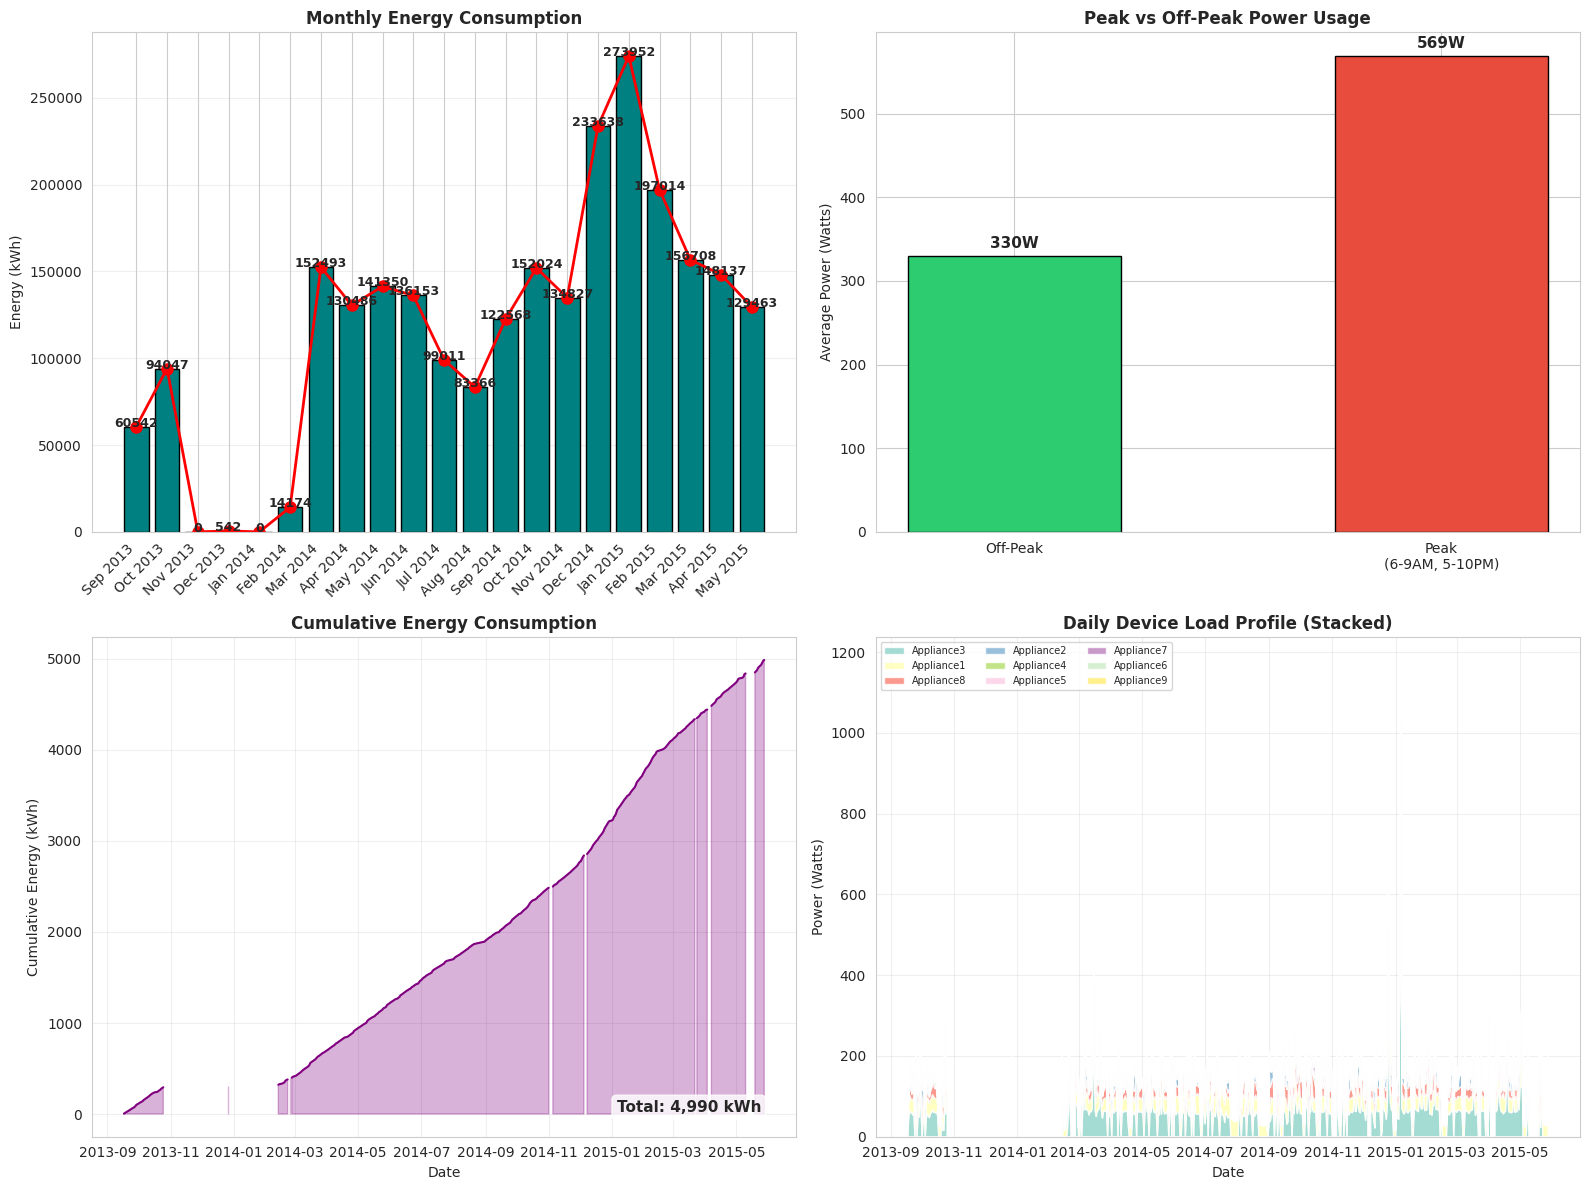

✅ Saved: reports/figures/milestone1_eda_full.png


In [ ]:
# Note: Uses df_pivot (original column names) since this runs before device mapping
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

print("=" * 70)
print("EXPLORATORY DATA ANALYSIS - UNIQUE INSIGHTS")
print("=" * 70)

# Use df_pivot (available at this point with original names)
df_plot = df_pivot.copy()

# Get column names dynamically
total_col = 'Aggregate'
appliance_cols = [c for c in df_plot.columns if c.startswith('Appliance')]
power_cols = [total_col] + appliance_cols

print(f"Total column: {total_col}")
print(f"Appliance columns: {appliance_cols}")

fig = plt.figure(figsize=(16, 12))

# -----------------------------------------------------------------------------
# PLOT 1: Monthly Energy Consumption Trend
# -----------------------------------------------------------------------------
ax1 = fig.add_subplot(2, 2, 1)
monthly = df_plot[total_col].resample('M').sum() / 1000  # Convert to kWh
ax1.bar(range(len(monthly)), monthly.values, color='teal', edgecolor='black')
ax1.plot(range(len(monthly)), monthly.values, 'ro-', linewidth=2, markersize=8)
ax1.set_xticks(range(len(monthly)))
month_labels = [d.strftime('%b %Y') for d in monthly.index]
ax1.set_xticklabels(month_labels, rotation=45, ha='right')
ax1.set_title('Monthly Energy Consumption', fontsize=12, fontweight='bold')
ax1.set_ylabel('Energy (kWh)')
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(monthly.values):
    ax1.text(i, v + 5, f'{v:.0f}', ha='center', fontsize=9, fontweight='bold')

# -----------------------------------------------------------------------------
# PLOT 2: Peak vs Off-Peak Consumption
# -----------------------------------------------------------------------------
ax2 = fig.add_subplot(2, 2, 2)
df_temp = df_plot.copy()
df_temp['hour'] = df_temp.index.hour
df_temp['period'] = df_temp['hour'].apply(
    lambda h: 'Peak\n(6-9AM, 5-10PM)' if (6 <= h <= 9) or (17 <= h <= 22) else 'Off-Peak'
)
period_avg = df_temp.groupby('period')[total_col].mean()
colors_period = ['#2ecc71', '#e74c3c']  # Green for off-peak, Red for peak
bars = ax2.bar(period_avg.index, period_avg.values, color=colors_period, edgecolor='black', width=0.5)
ax2.set_title('Peak vs Off-Peak Power Usage', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Power (Watts)')
for i, v in enumerate(period_avg.values):
    ax2.text(i, v + 10, f'{v:.0f}W', ha='center', fontsize=11, fontweight='bold')

# -----------------------------------------------------------------------------
# PLOT 3: Cumulative Energy Over Time
# -----------------------------------------------------------------------------
ax3 = fig.add_subplot(2, 2, 3)
# Resample to daily first to reduce data points
daily_total = df_plot[total_col].resample('D').mean()
cumulative = (daily_total.cumsum() * 24 / 1000)  # Convert to kWh (avg watts * 24h / 1000)
ax3.fill_between(cumulative.index, cumulative.values, alpha=0.3, color='purple')
ax3.plot(cumulative.index, cumulative.values, color='purple', linewidth=1.5)
ax3.set_title('Cumulative Energy Consumption', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Energy (kWh)')
ax3.grid(True, alpha=0.3)
total_kwh = cumulative.iloc[-1]
ax3.text(0.95, 0.05, f'Total: {total_kwh:,.0f} kWh', transform=ax3.transAxes,
         fontsize=11, fontweight='bold', ha='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# -----------------------------------------------------------------------------
# PLOT 4: Device Load Profile (Stacked Area - Daily Average)
# -----------------------------------------------------------------------------
ax4 = fig.add_subplot(2, 2, 4)
daily_devices = df_plot[appliance_cols].resample('D').mean()
sorted_cols = daily_devices.mean().sort_values(ascending=False).index.tolist()
colors_stack = plt.cm.Set3(np.linspace(0, 1, len(sorted_cols)))
ax4.stackplot(daily_devices.index, [daily_devices[col] for col in sorted_cols],
              labels=sorted_cols, colors=colors_stack, alpha=0.8)
ax4.set_title('Daily Device Load Profile (Stacked)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Power (Watts)')
ax4.legend(loc='upper left', fontsize=7, ncol=3)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/figures/milestone1_eda_full.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/milestone1_eda_full.png")

Resample to Hourly and Daily Energy

In [ ]:
print("\n" + "=" * 60)
print("DATA RESAMPLING")
print("=" * 60)

# Check df_pivot size
print(f"\n📊 Original df_pivot: {df_pivot.shape}")

# HOURLY: Mean power per hour
print("\n⏰ Creating HOURLY aggregated data...")
df_hourly = df_pivot.resample('h').mean()
df_hourly = df_hourly.ffill().bfill()

print(f"   Shape: {df_hourly.shape}")
print(f"   Range: {df_hourly.index.min()} to {df_hourly.index.max()}")
print(f"   Total hours: {len(df_hourly):,}")

# DAILY: Mean power per day
print("\n📅 Creating DAILY aggregated data...")
df_daily = df_pivot.resample('D').mean()

df_daily = df_daily.ffill().bfill()
print(f"   Shape: {df_daily.shape}")
print(f"   Range: {df_daily.index.min()} to {df_daily.index.max()}")
print(f"   Total days: {len(df_daily):,}")

# Fix timezone issue before saving (removes timezone info to speed up save)
print("\n💾 Saving files...")

# Remove timezone for faster CSV save
if df_hourly.index.tz is not None:
    df_hourly.index = df_hourly.index.tz_localize(None)
if df_daily.index.tz is not None:
    df_daily.index = df_daily.index.tz_localize(None)

# Save with optimized settings
df_hourly.to_csv('data/processed/hourly_energy.csv', date_format='%Y-%m-%d %H:%M:%S')
print("✅ Saved: data/processed/hourly_energy.csv")

df_daily.to_csv('data/processed/daily_energy.csv', date_format='%Y-%m-%d')
print("✅ Saved: data/processed/daily_energy.csv")

print(f"\n📁 File sizes:")
import os
print(f"   hourly_energy.csv: {os.path.getsize('data/processed/hourly_energy.csv')/1024:.1f} KB")
print(f"   daily_energy.csv: {os.path.getsize('data/processed/daily_energy.csv')/1024:.1f} KB")


DATA RESAMPLING

📊 Original df_pivot: (5733526, 10)

⏰ Creating HOURLY aggregated data...
   Shape: (14819, 10)
   Range: 2013-09-17 22:00:00+00:00 to 2015-05-28 08:00:00+00:00
   Total hours: 14,819

📅 Creating DAILY aggregated data...
   Shape: (619, 10)
   Range: 2013-09-17 00:00:00+00:00 to 2015-05-28 00:00:00+00:00
   Total days: 619

💾 Saving files...
✅ Saved: data/processed/hourly_energy.csv
✅ Saved: data/processed/daily_energy.csv

📁 File sizes:
   hourly_energy.csv: 1474.9 KB
   daily_energy.csv: 92.8 KB



Visualize Resampled Data

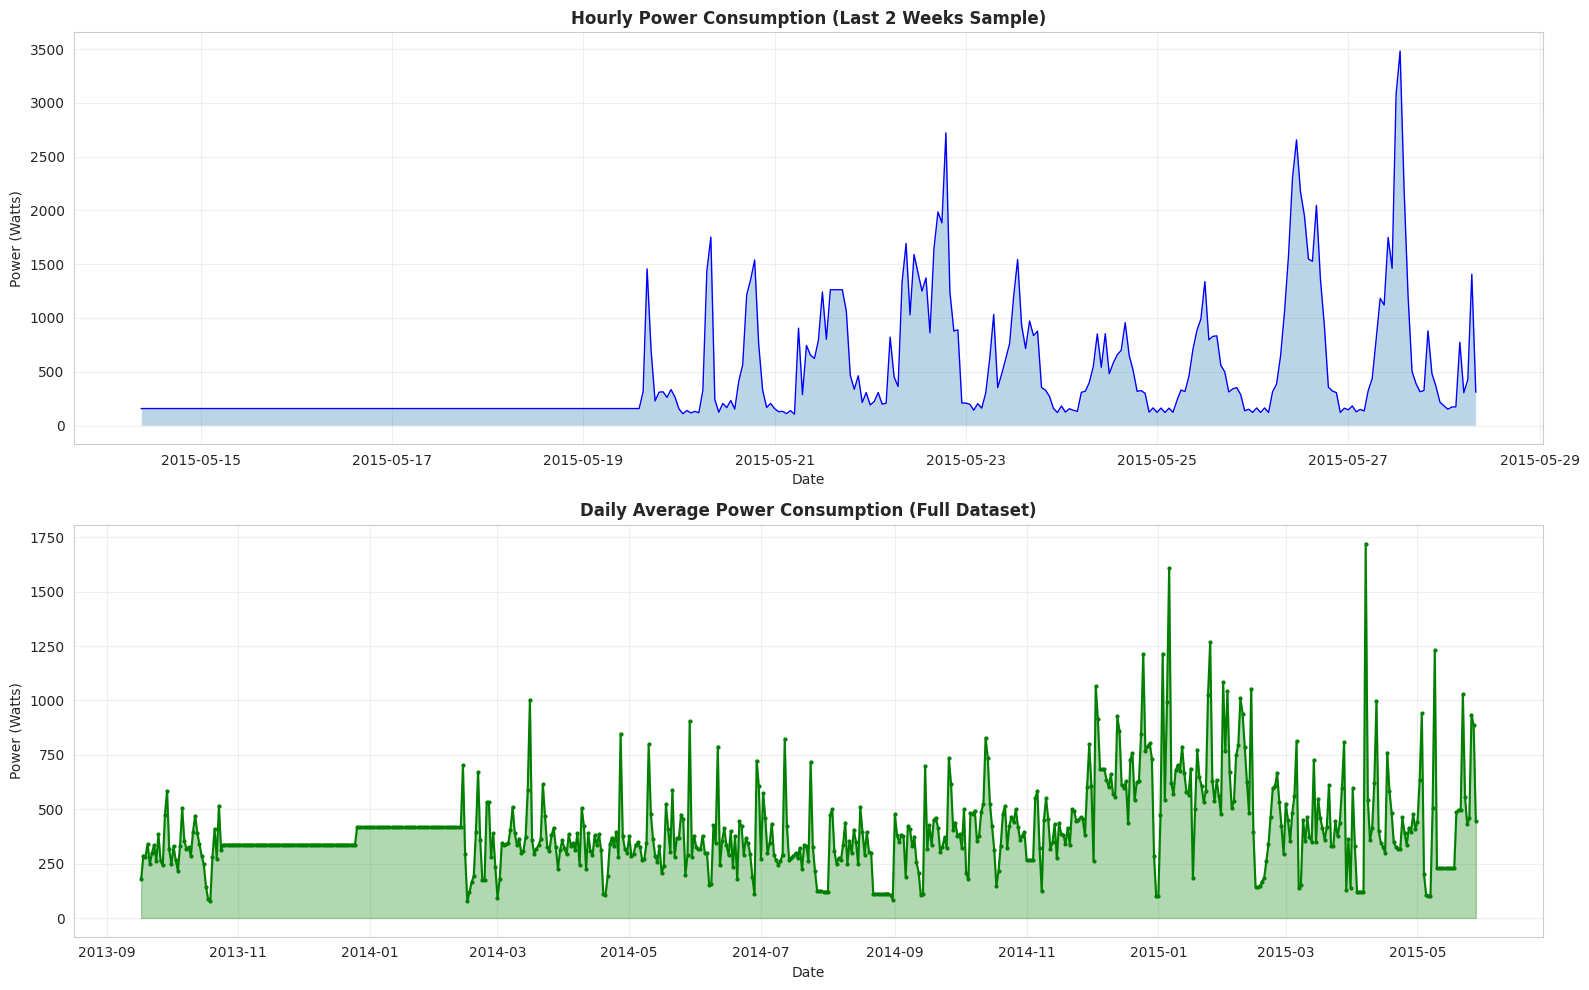

✅ Saved: reports/figures/resampled_data.png


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Hourly (show last 2 weeks for detail)
ax1 = axes[0]
last_2weeks = df_hourly['Aggregate'].iloc[-336:]  # 14 days × 24 hours
ax1.plot(last_2weeks.index, last_2weeks.values, linewidth=1, color='blue')
ax1.fill_between(last_2weeks.index, last_2weeks.values, alpha=0.3)
ax1.set_title('Hourly Power Consumption (Last 2 Weeks Sample)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power (Watts)')
ax1.grid(True, alpha=0.3)

# Daily (full dataset)
ax2 = axes[1]
ax2.plot(df_daily.index, df_daily['Aggregate'].values, linewidth=1.5, color='green', marker='o', markersize=2)
ax2.fill_between(df_daily.index, df_daily['Aggregate'].values, alpha=0.3, color='green')
ax2.set_title('Daily Average Power Consumption (Full Dataset)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Power (Watts)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('reports/figures/resampled_data.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/resampled_data.png")

 Normalize and Split Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

print("\n" + "=" * 60)
print("DATA NORMALIZATION AND SPLITTING")
print("=" * 60)

# Use hourly data for modeling
df_model = df_hourly.copy()
print(f"\n📊 Using HOURLY data for model: {df_model.shape}")

# Normalize using MinMaxScaler
print("\n🔄 Normalizing data (MinMaxScaler 0-1)...")
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_model),
    index=df_model.index,
    columns=df_model.columns
)
print(f"   Scaled range: [{df_scaled.min().min():.3f}, {df_scaled.max().max():.3f}]")

# Chronological Split: 70% train, 15% validation, 15% test
print("\n✂️ Splitting data chronologically (70/15/15)...")
n = len(df_scaled)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

train_df = df_scaled.iloc[:train_end]
val_df = df_scaled.iloc[train_end:val_end]
test_df = df_scaled.iloc[val_end:]

test_raw.to_csv(f'{splits_dir}/test_raw.csv')
print(f"\n   TRAIN: {train_df.shape[0]:,} samples")
print(f"          {train_df.index.min()} to {train_df.index.max()}")
print(f"   VAL:   {val_df.shape[0]:,} samples")
print(f"          {val_df.index.min()} to {val_df.index.max()}")
print(f"   TEST:  {test_df.shape[0]:,} samples")
print(f"          {test_df.index.min()} to {test_df.index.max()}")

# Also create unscaled splits for reference
train_raw = df_model.iloc[:train_end]
val_raw = df_model.iloc[train_end:val_end]
test_raw = df_model.iloc[val_end:]


DATA NORMALIZATION AND SPLITTING

📊 Using HOURLY data for model: (14819, 10)

🔄 Normalizing data (MinMaxScaler 0-1)...
   Scaled range: [0.000, 1.000]

✂️ Splitting data chronologically (70/15/15)...

   TRAIN: 10,373 samples
          2013-09-17 22:00:00 to 2014-11-24 02:00:00
   VAL:   2,223 samples
          2014-11-24 03:00:00 to 2015-02-24 17:00:00
   TEST:  2,223 samples
          2015-02-24 18:00:00 to 2015-05-28 08:00:00


 Save All Processed Data

In [ ]:
import pickle
import os

splits_dir = 'data/processed/splits'
os.makedirs(splits_dir, exist_ok=True)

print("\n" + "=" * 60)
print("SAVING ALL PROCESSED DATA")
print("=" * 60)

# Save scaled splits
train_df.to_csv(f'{splits_dir}/train_scaled.csv')
val_df.to_csv(f'{splits_dir}/val_scaled.csv')
test_df.to_csv(f'{splits_dir}/test_scaled.csv')
print("✅ Saved scaled splits (train/val/test_scaled.csv)")

# Save unscaled splits
train_raw.to_csv(f'{splits_dir}/train_raw.csv')
val_raw.to_csv(f'{splits_dir}/val_raw.csv')
test_raw.to_csv(f'{splits_dir}/test_raw.csv')
print("✅ Saved unscaled splits (train/val/test_raw.csv)")

# Save scaler for later use
with open('data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Saved: data/processed/scaler.pkl")

# Save hourly data (unscaled) for feature engineering
df_hourly.to_csv('data/processed/hourly_raw.csv')
print("✅ Saved: data/processed/hourly_raw.csv")

# List all saved files
print("\n📁 FILES IN data/processed/:")
for f in sorted(os.listdir('data/processed')):
    path = f'data/processed/{f}'
    if os.path.isfile(path):
        size = os.path.getsize(path) / 1024  # KB
        print(f"   {f}: {size:.1f} KB")
    else:
        print(f"   📂 {f}/")
        for sf in os.listdir(path):
            size = os.path.getsize(f'{path}/{sf}') / 1024
            print(f"      {sf}: {size:.1f} KB")


SAVING ALL PROCESSED DATA
✅ Saved scaled splits (train/val/test_scaled.csv)
✅ Saved unscaled splits (train/val/test_raw.csv)
✅ Saved: data/processed/scaler.pkl
✅ Saved: data/processed/hourly_raw.csv

📁 FILES IN data/processed/:
   daily_energy.csv: 92.8 KB
   device_info.csv: 0.6 KB
   device_mapping.csv: 0.6 KB
   device_mapping.json: 1.0 KB
   📂 features/
      X_train.csv: 4661.1 KB
      y_train.csv: 376.3 KB
      X_val.csv: 967.5 KB
      y_val.csv: 75.5 KB
      X_test.csv: 949.7 KB
      y_test.csv: 77.0 KB
      X_test_lr.csv: 1650.0 KB
      X_val_lr.csv: 1719.0 KB
      X_train_lr.csv: 7904.9 KB
      all_features.json: 1.5 KB
      train_fe_full.csv: 8151.0 KB
      feature_importance_lr.csv: 3.6 KB
      top_50_features.json: 1.1 KB
   hourly_energy.csv: 1474.9 KB
   hourly_raw.csv: 1474.9 KB
   house2_pivoted.csv: 272937.7 KB
   📂 models/
      baseline_lr.pkl: 3.1 KB
      lr_feature_scaler.pkl: 3.7 KB
      lr_baseline_metrics.csv: 0.1 KB
   room_energy.csv: 161061.5 K

 DEVICE MAPPING - REFIT HOUSE 2 OFFICIAL

In [ ]:
# =============================================================================
# This cell defines the official appliance names for REFIT House 2
# Source: REFIT Dataset Documentation (Murray et al.)
# =============================================================================

print("=" * 70)
print("ADDING DEVICE-LEVEL MAPPING")
print("=" * 70)

# Official REFIT House 2 Appliance Mapping
DEVICE_NAMES = {
    'Appliance1': 'Fridge_Freezer',
    'Appliance2': 'Washing_Machine',
    'Appliance3': 'Dishwasher',
    'Appliance4': 'Television',
    'Appliance5': 'Microwave',
    'Appliance6': 'Toaster',
    'Appliance7': 'HiFi',
    'Appliance8': 'Kettle',
    'Appliance9': 'Overhead_Fan'
}

# Room locations for each device
DEVICE_ROOMS = {
    'Aggregate': 'Whole_House',
    'Fridge_Freezer': 'Kitchen',
    'Washing_Machine': 'Utility',
    'Dishwasher': 'Kitchen',
    'Television': 'Living_Room',
    'Microwave': 'Kitchen',
    'Toaster': 'Kitchen',
    'HiFi': 'Living_Room',
    'Kettle': 'Kitchen',
    'Overhead_Fan': 'Bedroom'
}

# Device categories (useful for grouping)
DEVICE_CATEGORY = {
    'Aggregate': 'Total',
    'Fridge_Freezer': 'Cold_Appliance',
    'Washing_Machine': 'Wet_Appliance',
    'Dishwasher': 'Wet_Appliance',
    'Television': 'Entertainment',
    'Microwave': 'Cooking',
    'Toaster': 'Cooking',
    'HiFi': 'Entertainment',
    'Kettle': 'Cooking',
    'Overhead_Fan': 'Climate'
}

# Display mapping table
print("\n📱 OFFICIAL REFIT HOUSE 2 DEVICE MAPPING:")
print("-" * 70)
print(f"{'Original':<15} {'Device Name':<20} {'Room':<15} {'Category':<15}")
print("-" * 70)
print(f"{'Aggregate':<15} {'Aggregate':<20} {'Whole_House':<15} {'Total':<15}")
for old_name, new_name in DEVICE_NAMES.items():
    room = DEVICE_ROOMS.get(new_name, 'Unknown')
    category = DEVICE_CATEGORY.get(new_name, 'Unknown')
    print(f"{old_name:<15} {new_name:<20} {room:<15} {category:<15}")
print("-" * 70)

print("\n✅ Device mapping defined!")

ADDING DEVICE-LEVEL MAPPING

📱 OFFICIAL REFIT HOUSE 2 DEVICE MAPPING:
----------------------------------------------------------------------
Original        Device Name          Room            Category       
----------------------------------------------------------------------
Aggregate       Aggregate            Whole_House     Total          
Appliance1      Fridge_Freezer       Kitchen         Cold_Appliance 
Appliance2      Washing_Machine      Utility         Wet_Appliance  
Appliance3      Dishwasher           Kitchen         Wet_Appliance  
Appliance4      Television           Living_Room     Entertainment  
Appliance5      Microwave            Kitchen         Cooking        
Appliance6      Toaster              Kitchen         Cooking        
Appliance7      HiFi                 Living_Room     Entertainment  
Appliance8      Kettle               Kitchen         Cooking        
Appliance9      Overhead_Fan         Bedroom         Climate        
-----------------------------

 LOAD EXISTING DATA AND APPLY DEVICE NAMES

In [ ]:
# =============================================================================
# Load the already processed data and rename columns to device names
# =============================================================================

import pandas as pd
import pickle

print("=" * 70)
print("APPLYING DEVICE NAMES TO SAVED DATA")
print("=" * 70)

# Load hourly data
print("\n📂 Loading saved hourly data...")
df_hourly = pd.read_csv('data/processed/hourly_raw.csv', index_col=0, parse_dates=True)
print(f"   Loaded shape: {df_hourly.shape}")
print(f"   Current columns: {df_hourly.columns.tolist()}")

# Rename columns
df_hourly_named = df_hourly.rename(columns=DEVICE_NAMES)

# Update column lists
power_cols_named = ['Aggregate'] + list(DEVICE_NAMES.values())
power_cols_named = [c for c in power_cols_named if c in df_hourly_named.columns]
appliance_cols_named = [c for c in power_cols_named if c != 'Aggregate']

print(f"\n✅ Columns renamed!")
print(f"   New columns: {df_hourly_named.columns.tolist()}")

# Load daily data and rename
df_daily = pd.read_csv('data/processed/daily_energy.csv', index_col=0, parse_dates=True)
df_daily_named = df_daily.rename(columns=DEVICE_NAMES)

# Load splits and rename
train_raw = pd.read_csv('data/processed/splits/train_raw.csv', index_col=0, parse_dates=True)
val_raw = pd.read_csv('data/processed/splits/val_raw.csv', index_col=0, parse_dates=True)
test_raw = pd.read_csv('data/processed/splits/test_raw.csv', index_col=0, parse_dates=True)

train_raw_named = train_raw.rename(columns=DEVICE_NAMES)
val_raw_named = val_raw.rename(columns=DEVICE_NAMES)
test_raw_named = test_raw.rename(columns=DEVICE_NAMES)

train_scaled = pd.read_csv('data/processed/splits/train_scaled.csv', index_col=0, parse_dates=True)
val_scaled = pd.read_csv('data/processed/splits/val_scaled.csv', index_col=0, parse_dates=True)
test_scaled = pd.read_csv('data/processed/splits/test_scaled.csv', index_col=0, parse_dates=True)

train_scaled_named = train_scaled.rename(columns=DEVICE_NAMES)
val_scaled_named = val_scaled.rename(columns=DEVICE_NAMES)
test_scaled_named = test_scaled.rename(columns=DEVICE_NAMES)

print("✅ All data renamed successfully!")

APPLYING DEVICE NAMES TO SAVED DATA

📂 Loading saved hourly data...
   Loaded shape: (14819, 10)
   Current columns: ['Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9']

✅ Columns renamed!
   New columns: ['Aggregate', 'Fridge_Freezer', 'Washing_Machine', 'Dishwasher', 'Television', 'Microwave', 'Toaster', 'HiFi', 'Kettle', 'Overhead_Fan']
✅ All data renamed successfully!


 CREATE DEVICE INFORMATION TABLE

In [ ]:
# =============================================================================
# Summary statistics for each device with meaningful names
# =============================================================================

print("=" * 70)
print("DEVICE INFORMATION TABLE")
print("=" * 70)

device_info_list = []

for device in power_cols_named:
    room = DEVICE_ROOMS.get(device, 'Unknown')
    category = DEVICE_CATEGORY.get(device, 'Unknown')

    # Calculate statistics
    avg_power = df_hourly_named[device].mean()
    max_power = df_hourly_named[device].max()
    min_power = df_hourly_named[device].min()
    std_power = df_hourly_named[device].std()

    # Usage percentage (device ON when power > 10W)
    usage_pct = (df_hourly_named[device] > 10).mean() * 100

    # Total energy (approximate kWh)
    total_hours = len(df_hourly_named)
    total_kwh = (avg_power * total_hours) / 1000

    device_info_list.append({
        'Device': device,
        'Room': room,
        'Category': category,
        'Avg_Power_W': round(avg_power, 1),
        'Max_Power_W': round(max_power, 1),
        'Std_Power_W': round(std_power, 1),
        'Usage_%': round(usage_pct, 1),
        'Total_kWh': round(total_kwh, 1)
    })

device_info_df = pd.DataFrame(device_info_list)

print("\n" + device_info_df.to_string(index=False))

# Save device info
device_info_df.to_csv('data/processed/device_info.csv', index=False)
print(f"\n✅ Saved: data/processed/device_info.csv")

# Key insights
print("\n📊 KEY INSIGHTS:")
print("-" * 50)

# Exclude Aggregate for appliance-specific insights
appliance_info = device_info_df[device_info_df['Device'] != 'Aggregate']

highest = appliance_info.loc[appliance_info['Avg_Power_W'].idxmax()]
print(f"   🔴 Highest Avg Power: {highest['Device']} ({highest['Avg_Power_W']}W)")

most_used = appliance_info.loc[appliance_info['Usage_%'].idxmax()]
print(f"   ⏰ Most Used (ON time): {most_used['Device']} ({most_used['Usage_%']}%)")

most_energy = appliance_info.loc[appliance_info['Total_kWh'].idxmax()]
print(f"   ⚡ Most Energy Used: {most_energy['Device']} ({most_energy['Total_kWh']} kWh)")

# Room summary
print("\n🏠 ROOM SUMMARY:")
room_power = appliance_info.groupby('Room')['Avg_Power_W'].sum().sort_values(ascending=False)
for room, power in room_power.items():
    print(f"   {room}: {power:.1f}W average")

DEVICE INFORMATION TABLE

         Device        Room       Category  Avg_Power_W  Max_Power_W  Std_Power_W  Usage_%  Total_kWh
      Aggregate Whole_House          Total        418.4       4353.7        441.7    100.0     6200.2
 Fridge_Freezer     Kitchen Cold_Appliance         38.9        117.7         23.2     86.4      575.8
Washing_Machine     Utility  Wet_Appliance         23.6       1148.5         85.5     14.2      349.2
     Dishwasher     Kitchen  Wet_Appliance         46.4       2201.1        179.5      8.4      688.1
     Television Living_Room  Entertainment          5.2         53.6         10.8     21.8       76.6
      Microwave     Kitchen        Cooking         16.1        929.0         43.1     16.4      238.7
        Toaster     Kitchen        Cooking          1.2        176.7          8.6      2.3       17.4
           HiFi Living_Room  Entertainment          1.4         21.0          4.3      8.1       20.0
         Kettle     Kitchen        Cooking         18.4 

 EDA VISUALIZATIONS WITH DEVICE NAMES -  1

EDA WITH DEVICE NAMES


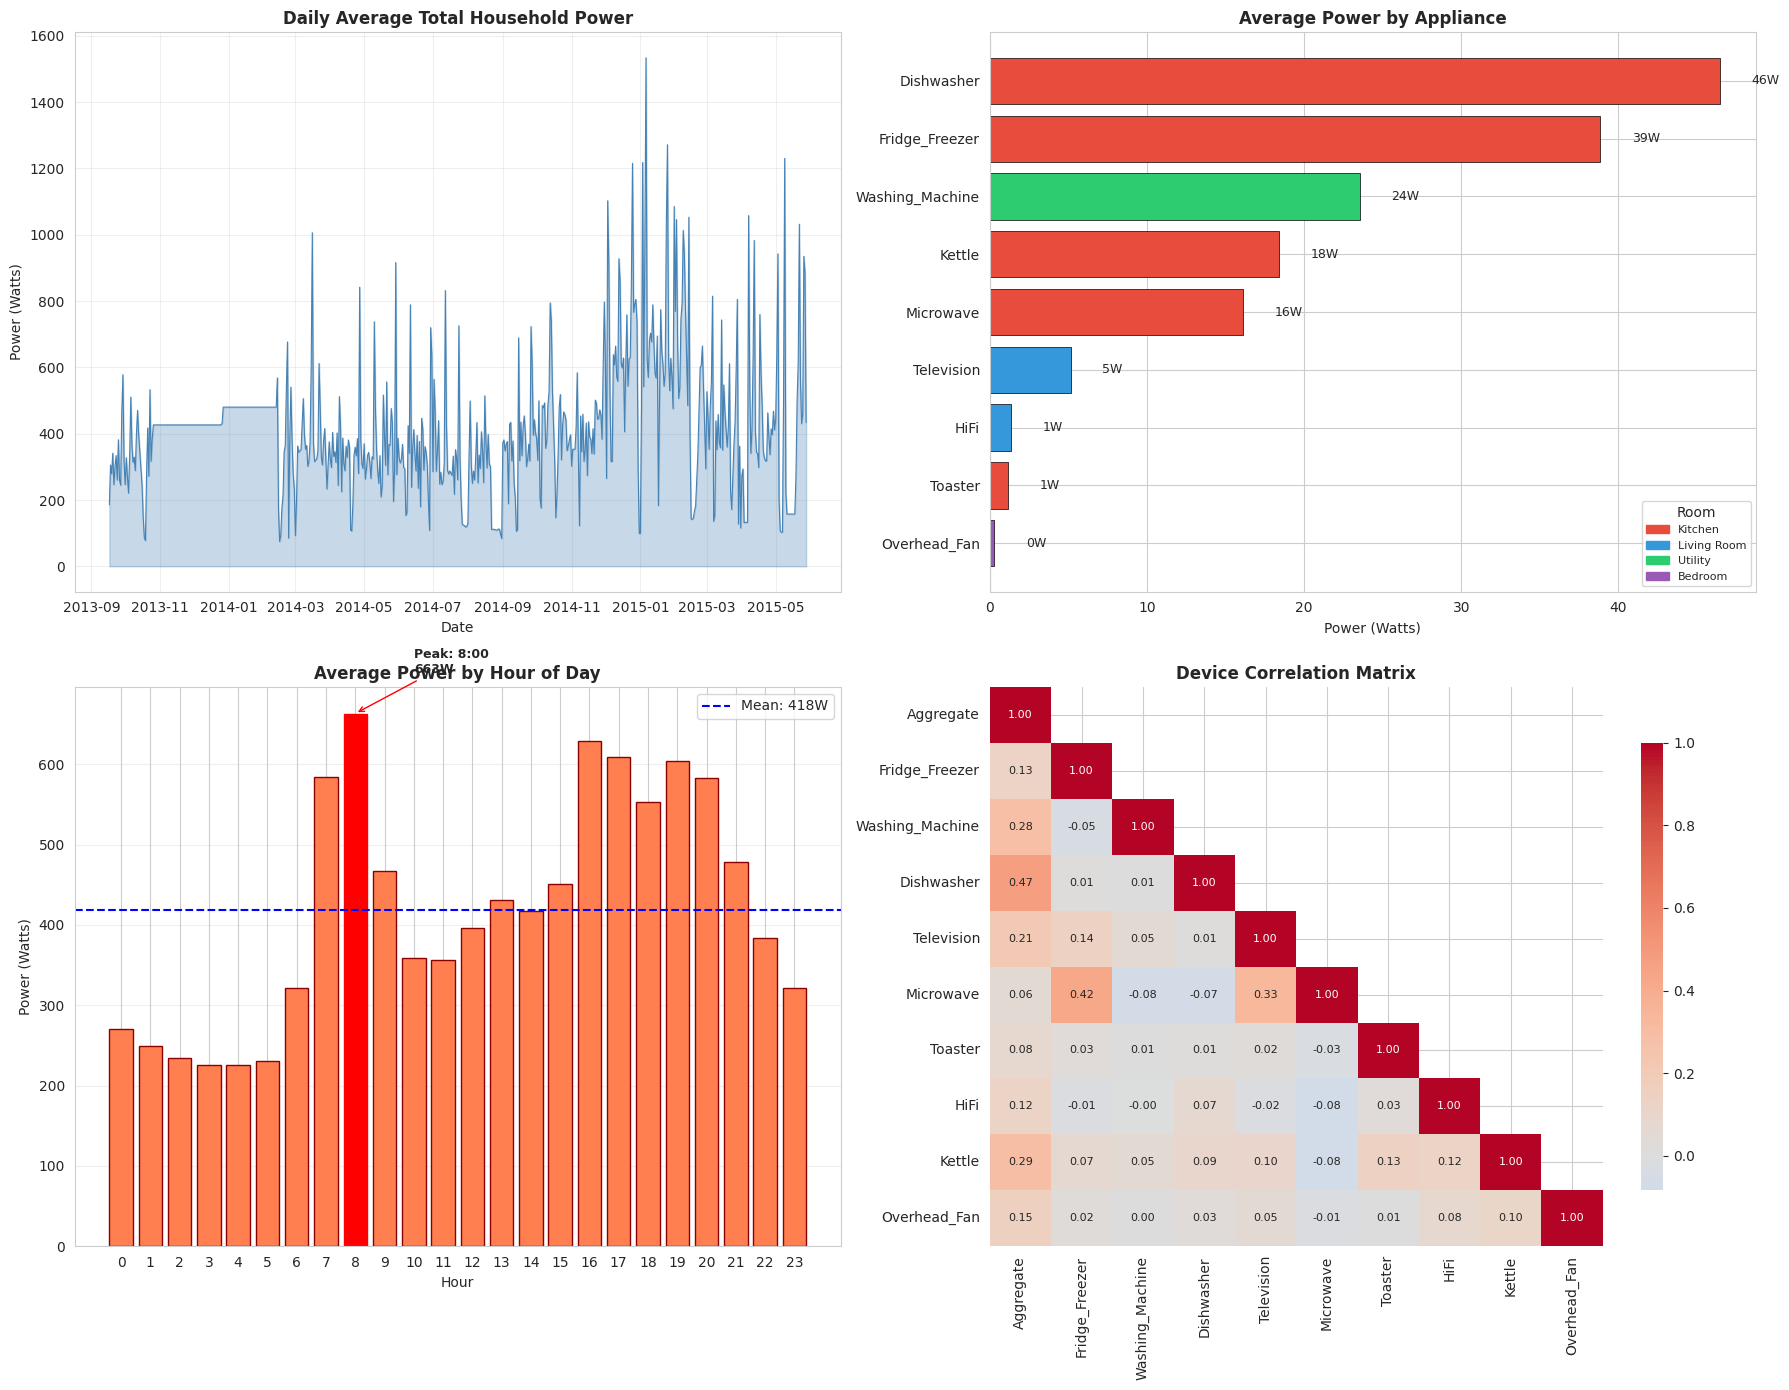

✅ Saved: reports/figures/eda_with_device_names.png


In [ ]:
# =============================================================================
# Re-create visualizations with meaningful device names
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("=" * 70)
print("EDA WITH DEVICE NAMES")
print("=" * 70)

fig = plt.figure(figsize=(18, 14))

# Color scheme by room
room_colors = {
    'Kitchen': '#e74c3c',       # Red
    'Living_Room': '#3498db',   # Blue
    'Utility': '#2ecc71',       # Green
    'Bedroom': '#9b59b6',       # Purple
    'Whole_House': '#34495e'    # Dark gray
}

# 1. Daily Power Consumption Over Time
ax1 = fig.add_subplot(2, 2, 1)
daily_power = df_hourly_named['Aggregate'].resample('D').mean()
ax1.plot(daily_power.index, daily_power.values, linewidth=0.8, color='steelblue')
ax1.fill_between(daily_power.index, daily_power.values, alpha=0.3, color='steelblue')
ax1.set_title('Daily Average Total Household Power', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power (Watts)')
ax1.grid(True, alpha=0.3)

# 2. Average Power by Device (with room colors)
ax2 = fig.add_subplot(2, 2, 2)
avg_power = df_hourly_named[appliance_cols_named].mean().sort_values(ascending=True)

# Get colors based on room
bar_colors = [room_colors.get(DEVICE_ROOMS.get(dev, 'Unknown'), '#95a5a6') for dev in avg_power.index]

bars = ax2.barh(range(len(avg_power)), avg_power.values, color=bar_colors, edgecolor='black', linewidth=0.5)
ax2.set_yticks(range(len(avg_power)))
ax2.set_yticklabels(avg_power.index)
ax2.set_title('Average Power by Appliance', fontsize=12, fontweight='bold')
ax2.set_xlabel('Power (Watts)')

# Add value labels
for i, v in enumerate(avg_power.values):
    ax2.text(v + 2, i, f'{v:.0f}W', va='center', fontsize=9)

# Add room legend
from matplotlib.patches import Patch
legend_rooms = ['Kitchen', 'Living_Room', 'Utility', 'Bedroom']
legend_patches = [Patch(color=room_colors[r], label=r.replace('_', ' ')) for r in legend_rooms]
ax2.legend(handles=legend_patches, loc='lower right', fontsize=8, title='Room')

# 3. Hourly Pattern with Peak Annotation
ax3 = fig.add_subplot(2, 2, 3)
hourly_pattern = df_hourly_named.groupby(df_hourly_named.index.hour)['Aggregate'].mean()
bars = ax3.bar(hourly_pattern.index, hourly_pattern.values, color='coral', edgecolor='darkred')

# Highlight peak hours
peak_hour = hourly_pattern.idxmax()
bars[peak_hour].set_color('red')
ax3.axhline(y=hourly_pattern.mean(), color='blue', linestyle='--', label=f'Mean: {hourly_pattern.mean():.0f}W')

ax3.set_title('Average Power by Hour of Day', fontsize=12, fontweight='bold')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Power (Watts)')
ax3.set_xticks(range(0, 24))
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Annotate peak
ax3.annotate(f'Peak: {peak_hour}:00\n{hourly_pattern.max():.0f}W',
             xy=(peak_hour, hourly_pattern.max()),
             xytext=(peak_hour+2, hourly_pattern.max()+50),
             fontsize=9, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='red'))

# 4. Correlation Heatmap with Device Names
ax4 = fig.add_subplot(2, 2, 4)
corr_matrix = df_hourly_named[power_cols_named].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax4, annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
ax4.set_title('Device Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/eda_with_device_names.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/eda_with_device_names.png")

 EDA VISUALIZATIONS WITH DEVICE NAMES - PART 2

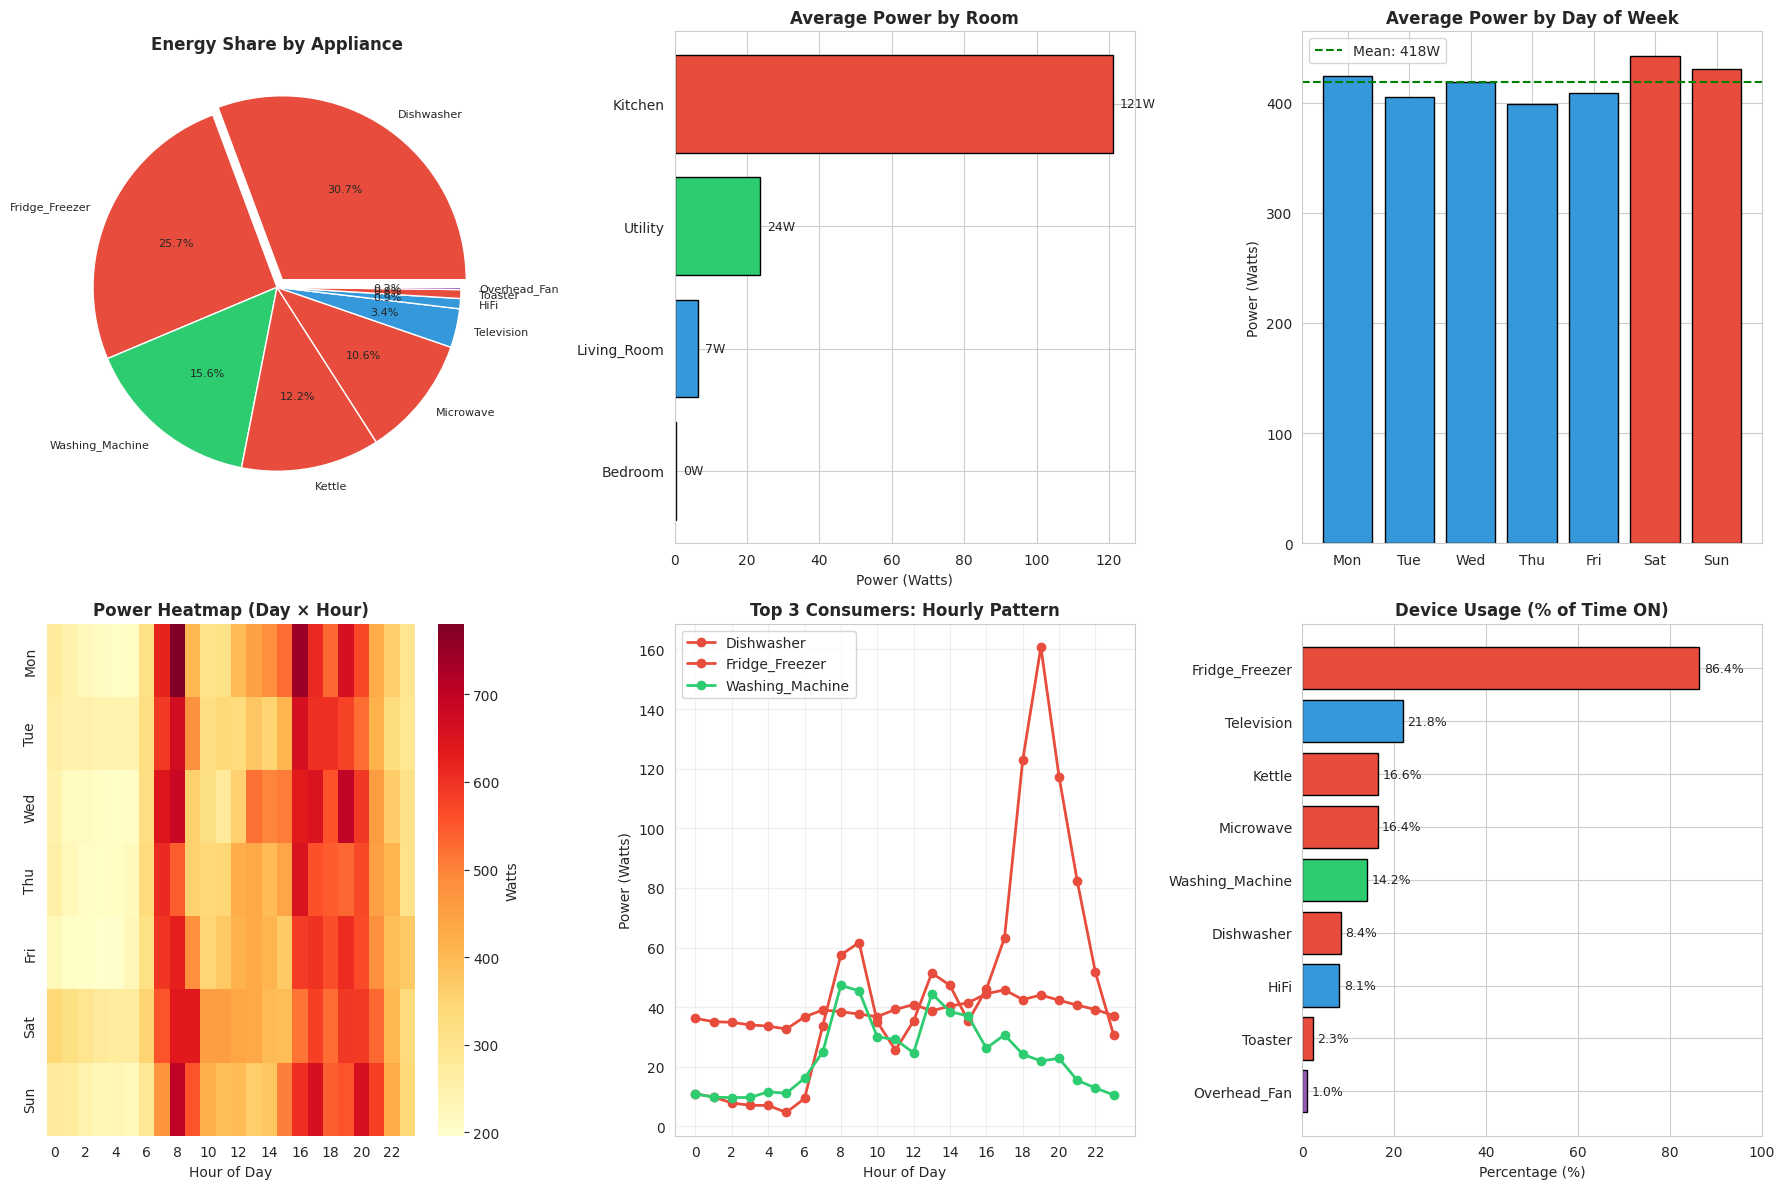

✅ Saved: reports/figures/eda_rooms_categories.png


In [ ]:
# =============================================================================
# Additional visualizations with room and category analysis
# =============================================================================

fig = plt.figure(figsize=(18, 12))

# 1. Energy Share Pie Chart
ax1 = fig.add_subplot(2, 3, 1)
energy_share = df_hourly_named[appliance_cols_named].sum().sort_values(ascending=False)
colors_pie = [room_colors.get(DEVICE_ROOMS.get(dev, 'Unknown'), '#95a5a6') for dev in energy_share.index]

wedges, texts, autotexts = ax1.pie(
    energy_share.values,
    labels=energy_share.index,
    autopct='%1.1f%%',
    colors=colors_pie,
    textprops={'fontsize': 8},
    explode=[0.05 if i == 0 else 0 for i in range(len(energy_share))]
)
ax1.set_title('Energy Share by Appliance', fontsize=12, fontweight='bold')

# 2. Power by Room (Grouped Bar)
ax2 = fig.add_subplot(2, 3, 2)
room_power = {}
for device in appliance_cols_named:
    room = DEVICE_ROOMS.get(device, 'Unknown')
    if room not in room_power:
        room_power[room] = 0
    room_power[room] += df_hourly_named[device].mean()

room_df = pd.Series(room_power).sort_values(ascending=True)
colors_room = [room_colors.get(r, '#95a5a6') for r in room_df.index]
ax2.barh(room_df.index, room_df.values, color=colors_room, edgecolor='black')
ax2.set_title('Average Power by Room', fontsize=12, fontweight='bold')
ax2.set_xlabel('Power (Watts)')
for i, v in enumerate(room_df.values):
    ax2.text(v + 2, i, f'{v:.0f}W', va='center', fontsize=9)

# 3. Weekly Pattern
ax3 = fig.add_subplot(2, 3, 3)
df_hourly_named['dow'] = df_hourly_named.index.dayofweek
weekly = df_hourly_named.groupby('dow')['Aggregate'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

colors_week = ['#3498db'] * 5 + ['#e74c3c'] * 2  # Blue weekdays, red weekends
ax3.bar(range(7), weekly.values, color=colors_week, edgecolor='black')
ax3.set_xticks(range(7))
ax3.set_xticklabels(days)
ax3.set_title('Average Power by Day of Week', fontsize=12, fontweight='bold')
ax3.set_ylabel('Power (Watts)')
ax3.axhline(y=weekly.mean(), color='green', linestyle='--', label=f'Mean: {weekly.mean():.0f}W')
ax3.legend()
df_hourly_named.drop('dow', axis=1, inplace=True)

# 4. Heatmap (Hour x Day) with better labels
ax4 = fig.add_subplot(2, 3, 4)
df_temp = df_hourly_named.copy()
df_temp['hour'] = df_temp.index.hour
df_temp['dow'] = df_temp.index.dayofweek
heatmap_data = df_temp.pivot_table(values='Aggregate', index='dow', columns='hour', aggfunc='mean')
heatmap_data.index = days
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Watts'})
ax4.set_title('Power Heatmap (Day × Hour)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('')

# 5. Top 3 Consumers - Hourly Pattern
ax5 = fig.add_subplot(2, 3, 5)
top3 = df_hourly_named[appliance_cols_named].mean().nlargest(3).index.tolist()
df_temp['hour'] = df_temp.index.hour

for device in top3:
    hourly = df_temp.groupby('hour')[device].mean()
    color = room_colors.get(DEVICE_ROOMS.get(device, 'Unknown'), '#95a5a6')
    ax5.plot(hourly.index, hourly.values, marker='o', label=device, linewidth=2, color=color)

ax5.set_title('Top 3 Consumers: Hourly Pattern', fontsize=12, fontweight='bold')
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Power (Watts)')
ax5.legend()
ax5.set_xticks(range(0, 24, 2))
ax5.grid(True, alpha=0.3)

# 6. Usage Percentage (% of time ON)
ax6 = fig.add_subplot(2, 3, 6)
usage_pct = {}
for device in appliance_cols_named:
    usage_pct[device] = (df_hourly_named[device] > 10).mean() * 100

usage_df = pd.Series(usage_pct).sort_values(ascending=True)
colors_usage = [room_colors.get(DEVICE_ROOMS.get(dev, 'Unknown'), '#95a5a6') for dev in usage_df.index]
ax6.barh(usage_df.index, usage_df.values, color=colors_usage, edgecolor='black')
ax6.set_title('Device Usage (% of Time ON)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Percentage (%)')
ax6.set_xlim(0, 100)
for i, v in enumerate(usage_df.values):
    ax6.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('reports/figures/eda_rooms_categories.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: reports/figures/eda_rooms_categories.png")

 SAVE ALL DATA WITH DEVICE NAMES

In [ ]:
# =============================================================================
# Re-save all processed data with meaningful device names
# =============================================================================

import os

print("=" * 70)
print("SAVING DATA WITH DEVICE NAMES")
print("=" * 70)

# Save hourly data with device names
df_hourly_named.to_csv('data/processed/hourly_raw.csv')
print("✅ Updated: data/processed/hourly_raw.csv")

# Save daily data with device names
df_daily_named.to_csv('data/processed/daily_energy.csv')
print("✅ Updated: data/processed/daily_energy.csv")

# Save splits with device names
train_raw_named.to_csv('data/processed/splits/train_raw.csv')
val_raw_named.to_csv('data/processed/splits/val_raw.csv')
test_raw_named.to_csv('data/processed/splits/test_raw.csv')
print("✅ Updated: data/processed/splits/*_raw.csv")

train_scaled_named.to_csv('data/processed/splits/train_scaled.csv')
val_scaled_named.to_csv('data/processed/splits/val_scaled.csv')
test_scaled_named.to_csv('data/processed/splits/test_scaled.csv')
print("✅ Updated: data/processed/splits/*_scaled.csv")

# Save device mapping as JSON for easy reference
import json

mapping_data = {
    'device_names': DEVICE_NAMES,
    'device_rooms': DEVICE_ROOMS,
    'device_categories': DEVICE_CATEGORY
}

with open('data/processed/device_mapping.json', 'w') as f:
    json.dump(mapping_data, f, indent=2)
print("✅ Saved: data/processed/device_mapping.json")

# List all files
print("\n📁 ALL PROCESSED FILES:")
print("-" * 50)
for root, dirs, files in os.walk('data/processed'):
    level = root.replace('data/processed', '').count(os.sep)
    indent = '   ' * level
    folder = os.path.basename(root) if level > 0 else 'data/processed'
    print(f"{indent}📂 {folder}/")
    for file in sorted(files):
        file_path = os.path.join(root, file)
        size_kb = os.path.getsize(file_path) / 1024
        print(f"{indent}   📄 {file} ({size_kb:.1f} KB)")

SAVING DATA WITH DEVICE NAMES
✅ Updated: data/processed/hourly_raw.csv
✅ Updated: data/processed/daily_energy.csv
✅ Updated: data/processed/splits/*_raw.csv
✅ Updated: data/processed/splits/*_scaled.csv
✅ Saved: data/processed/device_mapping.json

📁 ALL PROCESSED FILES:
--------------------------------------------------
📂 data/processed/
   📄 daily_energy.csv (91.8 KB)
   📄 device_info.csv (0.6 KB)
   📄 device_mapping.csv (0.6 KB)
   📄 device_mapping.json (1.0 KB)
   📄 hourly_energy.csv (1474.9 KB)
   📄 hourly_raw.csv (1468.6 KB)
   📄 house2_pivoted.csv (272937.7 KB)
   📄 room_energy.csv (161061.5 KB)
   📄 scaler.pkl (1.1 KB)
   📄 test.csv (62.9 KB)
   📄 train.csv (221.1 KB)
   📄 val.csv (41.0 KB)
   📂 splits/
      📄 test_raw.csv (213.4 KB)
      📄 test_scaled.csv (221.8 KB)
      📄 train_raw.csv (1036.1 KB)
      📄 train_scaled.csv (1077.9 KB)
      📄 val_raw.csv (219.3 KB)
      📄 val_scaled.csv (230.9 KB)
   📂 features/
      📄 X_test.csv (949.7 KB)
      📄 X_test_lr.csv (1650.0 KB

 UPDATED FINAL SUMMARY WITH DEVICE NAMES

In [ ]:
print("\n" + "=" * 70)
print("✅ MILESTONE 1 SUMMARY WITH DEVICE MAPPING")
print("=" * 70)

print(f"""
📊 DATASET INFORMATION:
   {'─'*55}
   Source:      REFIT Smart Home Dataset - House 2
   Start Date:  {df_hourly_named.index.min().date()}
   End Date:    {df_hourly_named.index.max().date()}
   Duration:    {(df_hourly_named.index.max() - df_hourly_named.index.min()).days} days

🏠 DEVICES MONITORED ({len(power_cols_named)} total):
   {'─'*55}""")

# Print device info with room and category
for device in power_cols_named:
    room = DEVICE_ROOMS.get(device, 'Unknown')
    category = DEVICE_CATEGORY.get(device, 'Unknown')
    avg_w = df_hourly_named[device].mean()
    print(f"   • {device:<18} | {room:<12} | {category:<12} | Avg: {avg_w:>6.0f}W")

print(f"""
📈 PROCESSED DATA:
   {'─'*55}
   Hourly samples: {len(df_hourly_named):,}
   Daily samples:  {len(df_daily_named):,}

✂️ DATA SPLITS:
   {'─'*55}
   Train:      {len(train_scaled_named):,} samples (70%)
   Validation: {len(val_scaled_named):,} samples (15%)
   Test:       {len(test_scaled_named):,} samples (15%)

📁 OUTPUT FILES:
   {'─'*55}
   ✓ data/processed/hourly_raw.csv (with device names)
   ✓ data/processed/daily_energy.csv (with device names)
   ✓ data/processed/device_info.csv
   ✓ data/processed/device_mapping.json
   ✓ data/processed/scaler.pkl
   ✓ data/processed/splits/*.csv (all with device names)

📊 FIGURES CREATED:
   {'─'*55}
   ✓ reports/figures/milestone1_eda_full.png (original)
   ✓ reports/figures/resampled_data.png (original)
   ✓ reports/figures/eda_with_device_names.png (4 plots)
   ✓ reports/figures/eda_rooms_categories.png (6 plots)

{'═'*70}
🎯 MILESTONE 1 COMPLETE WITH DEVICE-LEVEL MAPPING!
{'═'*70}
""")


✅ MILESTONE 1 SUMMARY WITH DEVICE MAPPING

📊 DATASET INFORMATION:
   ───────────────────────────────────────────────────────
   Source:      REFIT Smart Home Dataset - House 2
   Start Date:  2013-09-17
   End Date:    2015-05-28
   Duration:    617 days

🏠 DEVICES MONITORED (10 total):
   ───────────────────────────────────────────────────────
   • Aggregate          | Whole_House  | Total        | Avg:    418W
   • Fridge_Freezer     | Kitchen      | Cold_Appliance | Avg:     39W
   • Washing_Machine    | Utility      | Wet_Appliance | Avg:     24W
   • Dishwasher         | Kitchen      | Wet_Appliance | Avg:     46W
   • Television         | Living_Room  | Entertainment | Avg:      5W
   • Microwave          | Kitchen      | Cooking      | Avg:     16W
   • Toaster            | Kitchen      | Cooking      | Avg:      1W
   • HiFi               | Living_Room  | Entertainment | Avg:      1W
   • Kettle             | Kitchen      | Cooking      | Avg:     18W
   • Overhead_Fan       |

In [ ]:
# =============================================================================
# : FINAL VERIFICATION
# =============================================================================

print("🔍 FINAL VERIFICATION:")
print("-" * 50)

# Check that columns are renamed correctly
test_df = pd.read_csv('data/processed/hourly_raw.csv', index_col=0, nrows=5)
print(f"\n✅ hourly_raw.csv columns:")
print(f"   {test_df.columns.tolist()}")

# Check device_info.csv
device_info = pd.read_csv('data/processed/device_info.csv')
print(f"\n✅ device_info.csv:")
print(device_info[['Device', 'Room', 'Avg_Power_W']].to_string(index=False))

# Check device_mapping.json
import json
with open('data/processed/device_mapping.json', 'r') as f:
    mapping = json.load(f)
print(f"\n✅ device_mapping.json loaded with {len(mapping['device_names'])} devices")

# Check figures
figures = [
    'reports/figures/eda_with_device_names.png',
    'reports/figures/eda_rooms_categories.png'
]
for fig in figures:
    if os.path.exists(fig):
        size = os.path.getsize(fig) / 1024
        print(f"✅ {fig} ({size:.1f} KB)")
    else:
        print(f"❌ {fig} NOT FOUND")

print("\n" + "=" * 50)
print("🎉 ALL VERIFICATIONS PASSED!")
print("=" * 50)
print("\n📌 YOUR COLUMNS NOW SHOW DEVICE NAMES:")
print("   Appliance1 → Fridge_Freezer")
print("   Appliance2 → Washing_Machine")
print("   Appliance3 → Dishwasher")
print("   etc.")

🔍 FINAL VERIFICATION:
--------------------------------------------------

✅ hourly_raw.csv columns:
   ['Aggregate', 'Fridge_Freezer', 'Washing_Machine', 'Dishwasher', 'Television', 'Microwave', 'Toaster', 'HiFi', 'Kettle', 'Overhead_Fan']

✅ device_info.csv:
         Device        Room  Avg_Power_W
      Aggregate Whole_House        418.4
 Fridge_Freezer     Kitchen         38.9
Washing_Machine     Utility         23.6
     Dishwasher     Kitchen         46.4
     Television Living_Room          5.2
      Microwave     Kitchen         16.1
        Toaster     Kitchen          1.2
           HiFi Living_Room          1.4
         Kettle     Kitchen         18.4
   Overhead_Fan     Bedroom          0.3

✅ device_mapping.json loaded with 9 devices
✅ reports/figures/eda_with_device_names.png (952.5 KB)
✅ reports/figures/eda_rooms_categories.png (703.6 KB)

🎉 ALL VERIFICATIONS PASSED!

📌 YOUR COLUMNS NOW SHOW DEVICE NAMES:
   Appliance1 → Fridge_Freezer
   Appliance2 → Washing_Machine
   A